In [1]:
# Importing necessary libraries
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph,START,END
# from langchain_anthropic import ChatAnthropic
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage,HumanMessage
from langchain_core.runnables import RunnableConfig
from typing import TypedDict,List,Literal, Dict, Any
from typing_extensions import Annotated, Optional
from pydantic import BaseModel,Field
from dataclasses import dataclass, fields
from langchain.chat_models import init_chat_model
from tavily import AsyncTavilyClient
from enum import Enum
from langgraph.types import interrupt,Command
from langgraph.constants import Send
import asyncio
import operator
import uuid
from langgraph.checkpoint.memory import MemorySaver
load_dotenv()

True

In [2]:
# Loading the environment variables and model
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
# os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")
llm = ChatGroq(model="qwen-2.5-32b",temperature=0.1)

##### States

In [18]:
# Define the states and schema models
class UserRequirement(BaseModel):
    objective: str = Field(description="A brief statement outlining the primary goal or purpose of the application.")
    functional_requirements: str = Field(description="A detailed list of specific functionalities that the application must support to meet the user's needs.")
    non_functional_requirements: str = Field(description="A list of criteria that describe the quality attributes, performance, and constraints of the application.")

class RawRequirement(BaseModel):
    raw_requirement: UserRequirement

class UserStory(BaseModel):
    title: str = Field(description="Title of this user story")
    description: str = Field(description="Description of this user story")
    acceptance: str = Field(description="Acceptance criteria to mark this user story as aceepted")
    status: Literal["ToDo","Inprogess","Done"] = Field(description="Status of the user story, whether this user story is in Done, Inprogess or todo state")    
    technical_notes: str = Field(description="Add any implementation details or technical insights for developers")

class GeneratedCode(BaseModel):
    generated_code: str = Field(description="Generated code for the respective user story.")
            
class UserStories(BaseModel):
    stories : List[UserStory] = Field(description="User Stories related to project")

# States
class WorkFlowInputState(TypedDict):
    raw_requirements: str

class WorkflowState(TypedDict):
    raw_requirements: str
    user_requirement: UserRequirement
    # feedback_from_owner: str
    feedback_from_user: str
    stories : list[UserStory]
    completed_stories: Annotated[list,operator.add]
    codes: list[GeneratedCode]
    completed_code: Annotated[list,operator.add]
    
class UserStoryState(TypedDict):
    user_requirement: UserRequirement
    stories: list[UserStory]
    feedback_from_owner: str
    
class UserStoryOutputState(TypedDict):
    stories: list[UserStory]

class DesignDocumentState(TypedDict):
    stories: list[UserStory]
    design_document: str

class GenerateCodeState(TypedDict):
    codes: list[GeneratedCode]
    stories: list[UserStory]
    story: UserStory
    completed_code: Annotated[list,operator.add]
    


##### Prompts

In [19]:
# prompts
DEFAULT_USER_REQUIREMENTS_STRUCTURE = """
Please provide your application requirements using the following structure:

1. Objective
  - Briefly describe the main goal or purpose of the application.

2. Functional Requirements
  - List the specific functionalities you want the application to have. For example:
    - Users should be able to create, view, update, and delete tasks.
    - The application should allow users to set priorities for tasks.
    - Users should be able to search and filter tasks.

3. Non-functional Requirements
  - Specify any performance, security, or usability criteria. For example:
    - The application should load and respond quickly.
    - User data should be securely stored and protected.
    - The interface should be intuitive and easy to navigate.
"""

DEFAULT_USER_STORY_STRUCTURE = """
Please provide your user story using the following structured format to ensure clarity and completeness:

1. Title  
   - A short, descriptive name that summarizes the purpose of this user story.  
   - Example: "Automated Database Backup for System Reliability"

2. Description  
   - Provide additional details about the feature, functionality, or system behavior.  
   - Mention any business rules, constraints, or expected behaviors.  
   - Example:  
     - The system should perform full database backups every 24 hours.  
     - Backups should be stored securely in an encrypted cloud storage location.  
     - The system should automatically delete backups older than 30 days.  

3. Acceptance Criteria  
   - Clearly define the **conditions that must be met** for this user story to be considered complete.  
   - Each criterion should be **specific, measurable, and testable**.  
   - Example:  
     - The system must automatically back up the database every 24 hours.  
     - Backup files must be encrypted using AES-256 encryption.  
     - The system should notify the administrator via email on backup success or failure.  
     - Older backups should be automatically deleted after 30 days.     

4. Status  
   - Indicate the current progress of this user story in the development lifecycle.  
   - Options: **ToDo / Inprogress / Done**  
   - Example: **Inprogress**  

5. Technical Notes (Optional)  
   - Provide implementation details, architectural considerations, or any technical constraints developers should be aware of.  
   - Example:  
     - Use AWS SDK for S3 integration.  
     - Implement a cron job to schedule automated backups.  
     - Ensure logs are maintained for auditing backup processes.  

### Additional Guidelines:  
   - Keep each section **clear and concise**.  
   - Use **bullet points** for easy readability.  
"""

APPLICATION_DESCRIPTION = """
If applicable to the use case, generate the application description using the following structure:  

1. **Backend (if required):**  
   - Language: Python  
   - Framework: Flask/Django for API development  
   - Authentication: JWT-based authentication (if user authentication is needed)  
   - Database: PostgreSQL/MySQL (if data persistence is needed)  
   - API: RESTful endpoints for managing application functionalities  

2. **Frontend (if required):**  
   - Language: JavaScript/TypeScript (if a user interface is required)  
   - Framework: React/Angular/Vue.js (if applicable)  
   - UI Library: Material-UI / TailwindCSS for styling (if applicable)  

3. **Database (if required):**  
   - Relational database (PostgreSQL/MySQL) for structured data storage  
   - Tables: Define tables such as `tasks`, `users`, etc., based on the application's needs  
"""

user_requirements_instructions = """
I want a user requirements that is concise and focused.

<User Requirement>
The raw requirements provided by user
{user_requirements}
</User Requirement>

<Requirement organization>
The requirement should follow the below requirement structure
{requirement_organization}
</Requirement organization>


<Task>
Generate a structural user requirements using the provided raw user requirement.

For example, a good user requirement structure might look like:
1/ objective
2/ functional requirements
3/ non functional requirements

Before returning the user requirements, go through the each section of user requirments and mention if anything is missing
</Task>

<Feedback>
Here is feedback on the user requirement structure from review (if any):
{feedback}
</Feedback>

<Format>
Call the UserRequirement tool 
</Format>

<Instructions>
If any field in the raw requirements is unclear, please generate it yourself, ensure the generation follow the mention requirement_organization structure.
</Instructions>
"""

product_owner_instructions = """
I want a structured and well-reviewed user story that aligns with product requirements.

<User requirements>
Use the below user requirement to generate the user stories:
{user_requirements}
</User requirements>

<User Story Structure>  
The user stories should follow the below structure:  
{user_story_structure}  
</User Story Structure>  

<Task>  
Your task is to generate required number of user stories, which is based on the User requirements.
1. Review the user stories and check for completeness.  
2. Ensure the stories follows the correct structure, including:  
   - Title  
   - Description  
   - Acceptance Criteria  
   - Status  
   - Technical Notes (if applicable)  
3. If any field is missing or unclear, suggest improvements or generate the missing parts.  
4. Ensure that acceptance criteria are **clear, measurable, and testable**.  
5. Verify that the stories aligns with business goals and technical feasibility.  
</Task>  

<Feedback>  
Here is feedback from the product owner after review (if any):  
{feedback}  
</Feedback>  

<Format>  
Call the UserStory tool.  
</Format>  

<Instructions> 
- Keep each user story as separate task, so that it can be doable in define time frame.
- Do not create user story with more than 2 tasks in it.
- If any field in the user story is unclear, **propose improvements** based on best practices.  
- Ensure the final user story is well-structured, **developer-friendly, and testable**.  
- Align the user story with the **product vision and business objectives**.  
- Take product owner feedback, 
</Instructions>  
"""

refine_user_stories_instructions = """
You are an AI assistant that organizes and standardizes user stories.

<User Stories>
Here is a set of unordered user stories:  
{user_stories}  
</User Stories>

<User Story Structure>  
Ensure that each user story adheres to the following structure:  
{user_story_structure}  
</User Story Structure>

<Task>
Your task is to analyze the given user stories and reorder them logically, ensuring a coherent and progressive sequence.  
- Maintain the original format and preserve all details.  
- Improve readability where necessary without altering the intent of the stories.  
- Arrange foundational or prerequisite stories first, followed by dependent or advanced ones.  
- Ensure the final output strictly follows the provided structure.  
</Task>
"""

generate_design_document_instructions = """
You are an AI assistant that generates structured technical design documents for software applications based on user stories.

<User Stories>  
Here is a set of user stories that describe the application's functionality:  
{user_stories}  
</User Stories>

<Application Description>  
A high-level description of the application and its purpose:  
{application_description}  
</Application Description>


<Technical Design Structure>  
The document should follow this structured format:
1. **Overview** - Summarize the application, its purpose, and key functionalities.
2. **System Components** - List the backend, frontend, database, and other dependencies.
3. **Class and Function Definitions**  
   - Define core classes, their attributes, and descriptions.  
   - List methods with function names, arguments, return types, and explanations.  
   - Ensure function names and parameters align with the given user stories.  
4. **API Endpoints**  
   - Provide a table outlining HTTP methods, endpoints, and descriptions.  
   - Ensure that endpoints fulfill the user stories' requirements.  
5. **Database Schema**  
   - Present an SQL schema for database tables.  
   - Ensure tables and relationships align with the application's needs.  
</Technical Design Structure>

<Task>  
Your task is to generate a clear, structured, and professional technical design document based on the given user stories and application description.  
- Ensure that all functionalities from the user stories are covered in the design.  
- Maintain proper formatting and indentation.  
- Follow standard naming conventions for classes, functions, and API endpoints.  
- Ensure the design follows best practices for software architecture and system design.  
</Task>

<Instructions>
- Analyze the provided use case and determine which components are necessary.  
- Only include components that are relevant; do not generate unnecessary sections.  
- Maintain a structured format when generating the description.  
</Instructions>
"""


##### Refine the user requirements Node

In [20]:
def refine_user_requirments(state:WorkflowState):
    print("---- INTO THE USER REQUIREMENT NODE ----")
    raw_requirements = state["raw_requirements"]
    requirement_organization = DEFAULT_USER_REQUIREMENTS_STRUCTURE
    feedback_from_user = state.get("feedback_from_user",None)
    Requirement_Planner = ChatGroq(model="gemma2-9b-it",temperature=0.3).with_structured_output(RawRequirement)
    system_instructions = user_requirements_instructions.format(user_requirements=raw_requirements,requirement_organization=requirement_organization,feedback=feedback_from_user)
    requirement_result = Requirement_Planner.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate the user requirements as per organization given structure from the raw user requirements.")])
    return {"user_requirement":requirement_result.raw_requirement}

##### User requirement feedback Node

In [21]:
def human_feedback_user_requirments(state:WorkflowState) -> Command[Literal["refine_user_requirments","user_story_subgraph"]]:
    print("---- INTO THE HUMAN FEEDBACK NODE ----")
    user_req = f"""
    The user requirements are : 
    Objective : {state['user_requirement'].objective}\n
    Functional Requirement : {state['user_requirement'].functional_requirements}\n
    Non-functional Requirement : {state['user_requirement'].non_functional_requirements}\n
    """
    interrupt_message = f"""Please provide the feedback for the below user requirements.
                        \n{user_req}\nDoes the user requirements meet your needs?\nPass 'true' to approve the user requirements.\nOr, provide feedback to regenerate the user requirements:"""
    
    feedback = interrupt(value=interrupt_message)
    
    if isinstance(feedback, bool) and feedback is True:
        print("into the feedback boolean")
        return Command(goto="user_story_subgraph")
    
    elif isinstance(feedback, str):
        print("into the feedback string")
        return Command(goto="refine_user_requirments", update={"feedback_from_user": feedback})
    
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")

##### User Story Creation Subgraph

In [7]:
def generate_user_stories(state:UserStoryState):
    print("---- INTO THE generate_user_story NODE ----")
    user_requirements = state["user_requirement"]
    # user_stories = state.get("stories",None)
    feedback = state.get("feedback_from_owner",None)
    story_writer = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.3).with_structured_output(UserStories)
    system_message = product_owner_instructions.format(user_requirements=user_requirements,user_story_structure=DEFAULT_USER_STORY_STRUCTURE,feedback=feedback)
    stories = story_writer.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate user stories based on the provided user requirements.")])
    return {"stories":stories.stories}
    
def analyze_the_user_stories(state:UserStoryState):
    print("---- INTO THE ANALYZE USER STORY NODE ----")
    user_stories_str = ""
    for story in state["stories"]:
        user_stories_str += f"""\nTitle : {story.title} \nDescription : {story.description} \nAcceptance Criteria : {story.acceptance} \nStatus : {story.status} \nTechnical Notes : {story.technical_notes}\n"""
        
    system_message = refine_user_stories_instructions.format(user_stories=user_stories_str,user_story_structure=DEFAULT_USER_STORY_STRUCTURE)
    story_writer = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.3).with_structured_output(UserStories)
    stories = story_writer.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Reorder the user stories logically so that foundational stories come first, followed by dependent ones")])
    return {"stories":stories.stories}

def product_owner_feedback(state:UserStoryState):
    print("---- INTO THE PRODUCT OWNER FEEDBACK NODE ----")
    user_stories_str = ""
    
    for i,story in enumerate(state["stories"],start=1):
        user_stories_str += f"""\nUser Story : {i}\nTitle : {story.title} \nDescription : {story.description} \nAcceptance Criteria : {story.acceptance} \nStatus : {story.status} \nTechnical Notes : {story.technical_notes}\n"""
    
    feedback = interrupt(value=f"""The generated user stories are: \n {user_stories_str} \n Does this work for you? \n Please provide your feedback regarding the arrangement of the user stories.\nPass 'True' for no changes.""")
    
    if isinstance(feedback,bool) or feedback is True:
        print("into the feedback boolean")

        return Command(goto="dummy_node",update={"stories":state["stories"]},graph=Command.PARENT)
        # stories = state["stories"]
        # return Command(goto=[Send(node="generate_the_code",arg={"story":story}) for story in stories],update={"stories":state["stories"]},graph=Command.PARENT)
    
    elif isinstance(feedback,str):
        print("into the feedback string")
        return Command(goto="generate_user_stories",update={"feedback_from_owner":feedback,"stories":state["stories"]})
    
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")
    

section_builder = StateGraph(UserStoryState,output=UserStoryOutputState)
section_builder.add_node("generate_user_stories",generate_user_stories)
section_builder.add_node("analyze_the_user_stories",analyze_the_user_stories)
section_builder.add_node("product_owner_feedback",product_owner_feedback)

section_builder.add_edge(START, "generate_user_stories")
section_builder.add_edge("generate_user_stories", "analyze_the_user_stories")
section_builder.add_edge("analyze_the_user_stories", "product_owner_feedback")

user_story_subgraph = section_builder.compile()

##### Technical Design Document

In [22]:
def generate_design_document(state:DesignDocumentState):
    user_stories_str = ""
    for story in state["stories"]:
        user_stories_str += f"""\nTitle : {story.title} \nDescription : {story.description} \nAcceptance Criteria : {story.acceptance} \nStatus : {story.status} \nTechnical Notes : {story.technical_notes}\n"""
    
    system_message = generate_design_document_instructions.format(user_stories=user_stories_str,application_description=APPLICATION_DESCRIPTION)
    Document_Designer = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.3)
    desgin_document = Document_Designer.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the technical desgin document for the given usecase")])
    print("Type of document : ",type(desgin_document))
    return {"design_document":desgin_document}

##### Generate Code Node

In [8]:
def generate_the_code(state:GenerateCodeState):
    print("---- INTO THE GENERATE CODE NODE ----")
    print(state.get('story'))
   
    code_generator = llm.with_structured_output(GeneratedCode)
    system_message = "Generate the code in python using the given user story"
    generated_code = code_generator.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"The user story is {state.get('story')}")])
    
    print("Generated Code : ",generated_code)
    return {"code":generated_code,"completed_code":[generated_code.generated_code]}
    
def assign_workers(state: WorkflowState):
    """Assign a worker to each code generator to generate the code"""
    print("---- INTO THE ASSIGN WORKERS FUNCTION ----")
    return [Send("generate_the_code", {"story": story}) for story in state["stories"]]

def dummy_node(state:WorkflowState):
    print("---- INTO THE DUMMY NODE ----")
    print("state : ",state)

##### Build the Workflow

In [9]:
graph = StateGraph(state_schema=WorkflowState,input=WorkFlowInputState)
graph.add_node("refine_user_requirments",refine_user_requirments)
graph.add_node("human_feedback_user_requirments",human_feedback_user_requirments)
graph.add_node("user_story_subgraph",user_story_subgraph) # graph.add_node("user_story_subgraph",section_builder.compile())
graph.add_node("dummy_node",dummy_node)
graph.add_node("generate_the_code",generate_the_code)

graph.add_edge(START,"refine_user_requirments")
graph.add_edge("refine_user_requirments","human_feedback_user_requirments")
# graph.add_conditional_edges("user_story_subgraph",assign_workers,["generate_the_code"])
# graph.add_edge("user_story_subgraph","generate_the_code")
graph.add_edge("user_story_subgraph","dummy_node")
graph.add_conditional_edges("dummy_node",assign_workers,["generate_the_code"])
graph.add_edge("generate_the_code",END)

Workflow = graph.compile(MemorySaver())

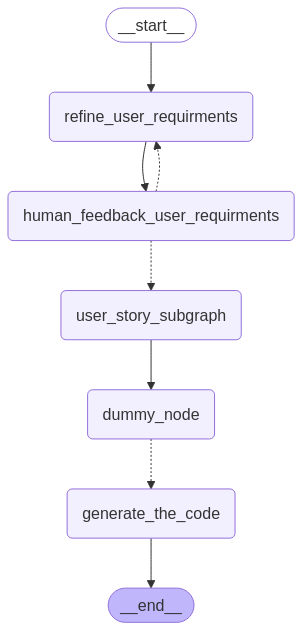

In [10]:
Workflow

In [11]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

##### Workflow testing 

In [12]:
raw_requirements = """create a todo list application in which users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. 
Users should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.The application should have a simple and intuitive user interface."""
for event in Workflow.stream(input={"raw_requirements":raw_requirements},stream_mode="updates",config=config):
    if "__interrupt__" in event:
        print(event["__interrupt__"][0].value)

---- INTO THE USER REQUIREMENT NODE ----
---- INTO THE HUMAN FEEDBACK NODE ----
Please provide the feedback for the below user requirements.
                        

    The user requirements are : 
    Objective : create a todo list application

    Functional Requirement : Users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. Users should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.

    Non-functional Requirement : The application should have a simple and intuitive user interface.

    
Does the user requirements meet your needs?
Pass 'true' to approve the user requirements.
Or, provide feedback to regenerate the user requirements:


In [13]:
for event in Workflow.stream(Command(resume="The application should have CRUD operations"),config=config,stream_mode="updates"):
    print(event)

---- INTO THE HUMAN FEEDBACK NODE ----
into the feedback string
{'human_feedback_user_requirments': {'feedback_from_user': 'The application should have CRUD operations'}}
---- INTO THE USER REQUIREMENT NODE ----
{'refine_user_requirments': {'user_requirement': UserRequirement(objective='create a todo list application', functional_requirements='Users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. \nUsers should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.', non_functional_requirements='The application should have a simple and intuitive user interface.')}}
---- INTO THE HUMAN FEEDBACK NODE ----
{'__interrupt__': (Interrupt(value="Please provide the feedback for the below user requirements.\n                        \n\n    The user requirements are : \n    Objective : create a todo list application\n\n    Functional Requirement : Users should be able to create, edit, and delete tas

In [14]:
for event in Workflow.stream(Command(resume=True),config=config,stream_mode="updates"):
    if '__interrupt__' in event:
        print(event["__interrupt__"][0].value)

---- INTO THE HUMAN FEEDBACK NODE ----
into the feedback boolean
---- INTO THE generate_user_story NODE ----
---- INTO THE ANALYZE USER STORY NODE ----
---- INTO THE PRODUCT OWNER FEEDBACK NODE ----
The generated user stories are: 
 
User Story : 1
Title : Create Tasks 
Description : Users should be able to create new tasks with a description and due date. 
Acceptance Criteria : The application allows users to create new tasks with a description and due date. The task is added to the list of all tasks. 
Status : ToDo 
Technical Notes : Use a form to collect task details and store them in a database.

User Story : 2
Title : View Task List 
Description : Users should be able to view a list of all tasks. 
Acceptance Criteria : The application displays a list of all tasks, with completed tasks visually distinguished from incomplete ones. 
Status : ToDo 
Technical Notes : Use a table or list to display all tasks, with a visual indicator (e.g. checkbox, color) to distinguish completed tasks.

In [15]:
for event in Workflow.stream(Command(resume=True),config=config,stream_mode="updates"):
    if '__interrupt__' in event:
        print(event["__interrupt__"][0].value)

---- INTO THE PRODUCT OWNER FEEDBACK NODE ----
into the feedback boolean
---- INTO THE DUMMY NODE ----
state :  {'raw_requirements': 'create a todo list application in which users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. \nUsers should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.The application should have a simple and intuitive user interface.', 'user_requirement': UserRequirement(objective='create a todo list application', functional_requirements='Users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. \nUsers should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.', non_functional_requirements='The application should have a simple and intuitive user interface.'), 'feedback_from_user': 'The application should have CRUD operations', 'stories': [UserStory(title='Create Tas

In [16]:
Workflow.get_state(config=config).values

{'raw_requirements': 'create a todo list application in which users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. \nUsers should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.The application should have a simple and intuitive user interface.',
 'user_requirement': UserRequirement(objective='create a todo list application', functional_requirements='Users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. \nUsers should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.', non_functional_requirements='The application should have a simple and intuitive user interface.'),
 'feedback_from_user': 'The application should have CRUD operations',
 'stories': [UserStory(title='Create Tasks', description='Users should be able to create new tasks with a description and due date.', acceptance='The